In [10]:
# Data Preprocessing for Lead Scoring
# Save this as preprocessing_notebook.ipynb

# Cell 1: Install and Import Dependencies
# Run this cell first
import pandas as pd
import numpy as np
import os
import pickle
import logging
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

# Cell 2: Configuration - UPDATE THESE PATHS
# Update these paths according to your system
INPUT_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\raw_data\Lead Scoring.csv"
OUTPUT_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output"

print(f"Input file: {INPUT_PATH}")
print(f"Output folder: {OUTPUT_PATH}")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_PATH, exist_ok=True)
print("✅ Output directory ready!")

# Cell 3: Setup Logging
def setup_logging(output_path):
    """Set up logging configuration"""
    log_dir = os.path.join(output_path, 'logs')
    os.makedirs(log_dir, exist_ok=True)
    
    log_file = os.path.join(log_dir, f'preprocessing_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
    
    # Clear any existing handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

# Initialize logger
logger = setup_logging(OUTPUT_PATH)
logger.info("📊 Starting Lead Scoring Data Preprocessing")

# Cell 4: Load and Explore Data
def load_data(input_path):
    """Load data from CSV file"""
    logger.info(f"Loading data from: {input_path}")
    try:
        df = pd.read_csv(input_path)
        logger.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logger.error(f"Error loading data: {str(e)}")
        raise

# Load the data
df = load_data(INPUT_PATH)

# Display basic information
print(f"📈 Dataset Shape: {df.shape}")
print(f"📊 Columns: {len(df.columns)}")
print("\n🔍 First few rows:")
print(df.head())

print("\n📋 Column Info:")
print(df.info())

print("\n🎯 Target Variable Distribution:")
if 'Converted' in df.columns:
    print(df['Converted'].value_counts())
else:
    print("No 'Converted' column found")

# Cell 5: Data Quality Analysis
print("🔍 Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

print("\n📊 Data Types:")
print(df.dtypes.value_counts())

# Cell 6: Drop Unnecessary Columns
def drop_unnecessary_columns(df):
    """Drop unnecessary columns"""
    drop_cols = [
        'Prospect ID', 'Lead Number', 'Magazine', 'Receive More Updates About Our Courses',
        'Update me on Supply Chain Content', 'Get updates on DM Content',
        'I agree to pay the amount through cheque', 'Search', 'Newspaper Article',
        'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations'
    ]
    
    existing_drop_cols = [col for col in drop_cols if col in df.columns]
    df_cleaned = df.drop(columns=existing_drop_cols)
    
    logger.info(f"Dropped {len(existing_drop_cols)} columns: {existing_drop_cols}")
    logger.info(f"Remaining columns: {len(df_cleaned.columns)}")
    
    return df_cleaned

# Apply column dropping
df_cleaned = drop_unnecessary_columns(df)
print(f"✅ Dropped unnecessary columns. New shape: {df_cleaned.shape}")
print(f"📋 Remaining columns: {list(df_cleaned.columns)}")

# Cell 7: Handle Missing Values
def fill_missing_values(df):
    """Fill missing values using different strategies"""
    df_filled = df.copy()
    
    # Numerical columns - fill with median
    numerical_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
                      'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
    
    print("🔢 Handling Numerical Columns:")
    for col_name in numerical_cols:
        if col_name in df_filled.columns:
            before_missing = df_filled[col_name].isnull().sum()
            median_val = df_filled[col_name].median()
            df_filled[col_name].fillna(median_val, inplace=True)
            logger.info(f"Filled {col_name} with median: {median_val}")
            print(f"  • {col_name}: {before_missing} missing values filled with median {median_val:.2f}")
    
    # Binary columns - fill with 'No'
    binary_cols = ['Do Not Email', 'Do Not Call', 'A free copy of Mastering The Interview']
    print("\n🔘 Handling Binary Columns:")
    for col_name in binary_cols:
        if col_name in df_filled.columns:
            before_missing = df_filled[col_name].isnull().sum()
            df_filled[col_name].fillna('No', inplace=True)
            logger.info(f"Filled {col_name} with 'No'")
            print(f"  • {col_name}: {before_missing} missing values filled with 'No'")
    
    # High cardinality columns - fill with mode
    high_card_cols = ['Tags', 'Lead Quality', 'Lead Profile', 'What is your current occupation',
                      'Last Activity', 'Last Notable Activity', 'Lead Source', 'Lead Origin']
    
    print("\n🏷️ Handling High Cardinality Columns:")
    for col_name in high_card_cols:
        if col_name in df_filled.columns:
            before_missing = df_filled[col_name].isnull().sum()
            mode_val = df_filled[col_name].mode()
            mode_value = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            df_filled[col_name].fillna(mode_value, inplace=True)
            logger.info(f"Filled {col_name} with mode: {mode_value}")
            print(f"  • {col_name}: {before_missing} missing values filled with mode '{mode_value}'")
    
    # Medium cardinality columns - fill with 'Unknown'
    medium_card_cols = ['Specialization', 'City', 'How did you hear about X Education',
                        'What matters most to you in choosing a course', 'Country']
    
    print("\n🌍 Handling Medium Cardinality Columns:")
    for col_name in medium_card_cols:
        if col_name in df_filled.columns:
            before_missing = df_filled[col_name].isnull().sum()
            df_filled[col_name].fillna('Unknown', inplace=True)
            logger.info(f"Filled {col_name} with 'Unknown'")
            print(f"  • {col_name}: {before_missing} missing values filled with 'Unknown'")
    
    return df_filled

# Apply missing value handling
df_filled = fill_missing_values(df_cleaned)
print(f"\n✅ Missing values handled. Final missing values: {df_filled.isnull().sum().sum()}")

# Cell 8: Feature Engineering Setup
def create_preprocessing_pipeline(df):
    """Create preprocessing pipeline"""
    logger.info("Creating preprocessing pipeline...")
    
    # Define column types
    numerical_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
                      'Asymmetrique Activity Score', 'Asymmetrique Profile Score']
    
    binary_cols = ['Do Not Email', 'Do Not Call', 'A free copy of Mastering The Interview']
    
    high_card_cols = ['Tags', 'Lead Quality', 'Lead Profile', 'What is your current occupation',
                      'Last Activity', 'Last Notable Activity', 'Lead Source', 'Lead Origin']
    
    medium_card_cols = ['Specialization', 'City', 'How did you hear about X Education',
                        'What matters most to you in choosing a course', 'Country']
    
    # Filter columns that exist in the dataframe
    existing_numerical = [col for col in numerical_cols if col in df.columns]
    existing_binary = [col for col in binary_cols if col in df.columns]
    existing_categorical = [col for col in high_card_cols + medium_card_cols if col in df.columns]
    
    print(f"🔢 Numerical columns to scale: {existing_numerical}")
    print(f"🔘 Binary columns to encode: {existing_binary}")
    print(f"🏷️ Categorical columns to encode: {existing_categorical}")
    
    # Create transformers
    transformers = []
    
    # Numerical columns - MinMax scaling
    if existing_numerical:
        transformers.append(('num', MinMaxScaler(), existing_numerical))
        logger.info(f"Added numerical transformer for: {existing_numerical}")
    
    # Categorical columns - OneHot encoding
    if existing_categorical:
        transformers.append(('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), existing_categorical))
        logger.info(f"Added categorical transformer for: {existing_categorical}")
    
    # Create column transformer
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    
    return preprocessor, existing_numerical, existing_binary, existing_categorical

# Create preprocessing pipeline
preprocessor, numerical_cols, binary_cols, categorical_cols = create_preprocessing_pipeline(df_filled)

# Cell 9: Binary Encoding
def encode_binary_columns(df, binary_cols):
    """Manually encode binary columns"""
    df_encoded = df.copy()
    
    print("🔄 Encoding Binary Columns:")
    for col_name in binary_cols:
        if col_name in df_encoded.columns:
            # Show value counts before encoding
            print(f"\n  • {col_name}:")
            print(f"    Before: {df_encoded[col_name].value_counts().to_dict()}")
            
            df_encoded[f"{col_name}_encoded"] = (df_encoded[col_name] == 'Yes').astype(int)
            logger.info(f"Encoded binary column: {col_name}")
            
            print(f"    After: {df_encoded[f'{col_name}_encoded'].value_counts().to_dict()}")
    
    return df_encoded

# Apply binary encoding
df_with_binary = encode_binary_columns(df_filled, binary_cols)

# Cell 10: Apply Preprocessing Pipeline
def preprocess_features(df_with_binary, preprocessor, numerical_cols, binary_cols, categorical_cols):
    """Apply preprocessing pipeline"""
    logger.info("Applying preprocessing pipeline...")
    
    # Prepare data for pipeline
    feature_cols = numerical_cols + categorical_cols
    X = df_with_binary[feature_cols] if feature_cols else pd.DataFrame()
    
    # Fit and transform the pipeline
    if not X.empty:
        print(f"🔄 Transforming {len(feature_cols)} features...")
        X_transformed = preprocessor.fit_transform(X)
        logger.info(f"Pipeline transformation completed. Output shape: {X_transformed.shape}")
        
        # Get feature names
        feature_names = []
        if numerical_cols:
            feature_names.extend(numerical_cols)
        if categorical_cols:
            try:
                cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
                feature_names.extend(cat_feature_names)
            except:
                # Fallback if get_feature_names_out is not available
                feature_names.extend([f"cat_{i}" for i in range(X_transformed.shape[1] - len(numerical_cols))])
        
        # Create DataFrame with transformed features
        df_transformed = pd.DataFrame(X_transformed, columns=feature_names, index=df_with_binary.index)
        print(f"✅ Created {len(feature_names)} transformed features")
    else:
        df_transformed = pd.DataFrame(index=df_with_binary.index)
        logger.warning("No features to transform with pipeline")
    
    # Add binary encoded columns
    binary_encoded_cols = [f"{col}_encoded" for col in binary_cols if col in df_with_binary.columns]
    for col in binary_encoded_cols:
        df_transformed[col] = df_with_binary[col]
    
    print(f"✅ Added {len(binary_encoded_cols)} binary encoded features")
    
    # Add target column if exists
    if 'Converted' in df_with_binary.columns:
        df_transformed['Converted'] = df_with_binary['Converted']
        logger.info("Added target column 'Converted'")
        print("✅ Added target column 'Converted'")
    
    return df_transformed

# Apply preprocessing
df_final = preprocess_features(df_with_binary, preprocessor, numerical_cols, binary_cols, categorical_cols)

print(f"\n🎉 Final processed data shape: {df_final.shape}")
print(f"📊 Final columns: {list(df_final.columns)}")

# Cell 11: Data Summary and Validation
print("📊 Final Dataset Summary:")
print(f"  • Total samples: {len(df_final)}")
print(f"  • Total features: {len(df_final.columns) - (1 if 'Converted' in df_final.columns else 0)}")
print(f"  • Target column: {'✅ Present' if 'Converted' in df_final.columns else '❌ Missing'}")

if 'Converted' in df_final.columns:
    print(f"\n🎯 Target Distribution:")
    target_dist = df_final['Converted'].value_counts()
    print(target_dist)
    print(f"  • Conversion Rate: {(target_dist[1] / len(df_final) * 100):.2f}%")

print(f"\n📈 Feature Types:")
feature_cols = [col for col in df_final.columns if col != 'Converted']
print(f"  • Numerical features: {len([col for col in feature_cols if col in numerical_cols])}")
print(f"  • Binary features: {len([col for col in feature_cols if col.endswith('_encoded')])}")
print(f"  • Categorical features: {len(feature_cols) - len(numerical_cols) - len([col for col in feature_cols if col.endswith('_encoded')])}")

# Cell 12: Save Results
def save_results(df_transformed, preprocessor, output_path):
    """Save processed data and pipeline"""
    logger.info(f"Saving results to: {output_path}")
    
    # Create output directories
    processed_dir = os.path.join(output_path, 'processed')
    os.makedirs(processed_dir, exist_ok=True)
    
    # Save processed data
    processed_data_path = os.path.join(processed_dir, 'preprocessed_data.csv')
    df_transformed.to_csv(processed_data_path, index=False)
    logger.info(f"Saved processed data to: {processed_data_path}")
    print(f"💾 Saved processed data to: {processed_data_path}")
    
    # Save pipeline
    pipeline_path = os.path.join(processed_dir, 'pipeline_model.pkl')
    with open(pipeline_path, 'wb') as f:
        pickle.dump(preprocessor, f)
    logger.info(f"Saved pipeline model to: {pipeline_path}")
    print(f"💾 Saved pipeline model to: {pipeline_path}")
    
    # Save metadata
    metadata = {
        'processed_data_shape': df_transformed.shape,
        'columns': list(df_transformed.columns),
        'processing_timestamp': datetime.now().isoformat(),
        'has_target': 'Converted' in df_transformed.columns,
        'numerical_features': numerical_cols,
        'binary_features': binary_cols,
        'categorical_features': categorical_cols
    }
    
    metadata_path = os.path.join(processed_dir, 'metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    logger.info(f"Saved metadata to: {metadata_path}")
    print(f"💾 Saved metadata to: {metadata_path}")
    
    return processed_data_path, pipeline_path, metadata_path

# Save all results
processed_data_path, pipeline_path, metadata_path = save_results(df_final, preprocessor, OUTPUT_PATH)

print(f"\n🎉 PREPROCESSING COMPLETE!")
print(f"📁 Output folder: {OUTPUT_PATH}")
print(f"📄 Processed data: {processed_data_path}")
print(f"🔧 Pipeline model: {pipeline_path}")
print(f"📋 Metadata: {metadata_path}")

# Cell 13: Quick Model Readiness Check
print("\n🤖 MODEL READINESS CHECK:")
print("✅ Data preprocessing complete")
print("✅ Missing values handled")
print("✅ Features encoded and scaled")
print("✅ Pipeline saved for future use")

if 'Converted' in df_final.columns:
    print("✅ Target variable present")
    print("\n🚀 Your data is ready for machine learning model training!")
else:
    print("⚠️  No target variable found")
    print("🔍 This data can be used for inference with a trained model")

# Cell 14: Optional - Display Sample of Final Data
print("\n📊 Sample of Final Processed Data:")
print(df_final.head())

print(f"\n📈 Final Data Statistics:")
print(df_final.describe())

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Minfy.DESKTOP-3E50D5N\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1153, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Minfy.DESKTOP-3E50D5N\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f4ca' in position 33: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\venv\Lib\site-package

✅ All libraries imported successfully!
Input file: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\raw_data\Lead Scoring.csv
Output folder: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output
✅ Output directory ready!


2025-07-17 19:02:27,800 - INFO - Data loaded successfully. Shape: (9240, 37)


📈 Dataset Shape: (9240, 37)
📊 Columns: 37

🔍 First few rows:
                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website 

2025-07-17 19:02:28,068 - INFO - Dropped 13 columns: ['Prospect ID', 'Lead Number', 'Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations']
2025-07-17 19:02:28,069 - INFO - Remaining columns: 24
2025-07-17 19:02:28,112 - INFO - Filled TotalVisits with median: 3.0
2025-07-17 19:02:28,118 - INFO - Filled Total Time Spent on Website with median: 248.0
2025-07-17 19:02:28,121 - INFO - Filled Page Views Per Visit with median: 2.0
2025-07-17 19:02:28,124 - INFO - Filled Asymmetrique Activity Score with median: 14.0
2025-07-17 19:02:28,127 - INFO - Filled Asymmetrique Profile Score with median: 16.0
2025-07-17 19:02:28,131 - INFO - Filled Do Not Email with 'No'
2025-07-17 19:02:28,134 - INFO - Filled Do Not Call with 'No'
2025-07-17 19:02:28,136 - INFO - Filled A free co

✅ Dropped unnecessary columns. New shape: (9240, 24)
📋 Remaining columns: ['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Tags', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'A free copy of Mastering The Interview', 'Last Notable Activity']
🔢 Handling Numerical Columns:
  • TotalVisits: 137 missing values filled with median 3.00
  • Total Time Spent on Website: 0 missing values filled with median 248.00
  • Page Views Per Visit: 137 missing values filled with median 2.00
  • Asymmetrique Activity Score: 4218 missing values filled with median 14.00
  • Asymmetrique Profile Score: 4218 missing values filled with

2025-07-17 19:02:28,377 - INFO - Pipeline transformation completed. Output shape: (9240, 176)
2025-07-17 19:02:28,381 - INFO - Added target column 'Converted'
2025-07-17 19:02:28,394 - INFO - Saving results to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output


✅ Created 176 transformed features
✅ Added 3 binary encoded features
✅ Added target column 'Converted'

🎉 Final processed data shape: (9240, 180)
📊 Final columns: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)', 'Tags_Graduation in progress', 'Tags_In confusion whether part time or DLP', 'Tags_Interested  in full time MBA', 'Tags_Interested in Next batch', 'Tags_Interested in other courses', 'Tags_Lateral student', 'Tags_Lost to EINS', 'Tags_Lost to Others', 'Tags_Not doing further education', 'Tags_Recognition issue (DEC approval)', 'Tags_Ringing', 'Tags_Shall take in the next coming month', 'Tags_Still Thinking', 'Tags_University not recognized', 'Tags_Want to take admission but has financial problems', 'Tags_Will revert after reading the email', 'Tags_in touch with EINS', 'Tags_invalid number', 'Tags_number not provided', 'T

2025-07-17 19:02:29,160 - INFO - Saved processed data to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\preprocessed_data.csv
2025-07-17 19:02:29,170 - INFO - Saved pipeline model to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\pipeline_model.pkl
2025-07-17 19:02:29,172 - INFO - Saved metadata to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\metadata.pkl


💾 Saved processed data to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\preprocessed_data.csv
💾 Saved pipeline model to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\pipeline_model.pkl
💾 Saved metadata to: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\metadata.pkl

🎉 PREPROCESSING COMPLETE!
📁 Output folder: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output
📄 Processed data: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\preprocessed_data.csv
🔧 Pipeline model: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\pipeline_model.pkl
📋 Metadata: C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\metadata.pkl

🤖 MODEL READINESS CHECK:
✅ Data preprocessing complete
✅ Missing valu

# testing the pipeline pkl file for the new data 

In [5]:
import pickle
import pandas as pd
import numpy as np

# Paths - make sure they match the ones you saved
PIPELINE_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\pipeline_model.pkl"
METADATA_PATH = r"C:\Users\Minfy.DESKTOP-3E50D5N\Desktop\final_capstone\preprocess\preprocessed_output\processed\metadata.pkl"

# Load pipeline
with open(PIPELINE_PATH, 'rb') as f:
    preprocessor = pickle.load(f)

# Load metadata
with open(METADATA_PATH, 'rb') as f:
    metadata = pickle.load(f)

numerical_cols = metadata['numerical_features']
categorical_cols = metadata['categorical_features']
binary_cols = metadata['binary_features']
print("✅ Pipeline and metadata loaded successfully!")


✅ Pipeline and metadata loaded successfully!


In [6]:
# Example: create one random test row (change values according to your understanding)
sample_input = pd.DataFrame([{
    'TotalVisits': 3,
    'Total Time Spent on Website': 1200,
    'Page Views Per Visit': 4,
    'Asymmetrique Activity Score': 80,
    'Asymmetrique Profile Score': 85,
    
    'Tags': 'Interested in other courses',
    'Lead Quality': 'High in Relevance',
    'Lead Profile': 'Working Professional',
    'What is your current occupation': 'Unemployed',
    'Last Activity': 'Email Opened',
    'Last Notable Activity': 'Modified',
    'Lead Source': 'Google',
    'Lead Origin': 'Landing Page Submission',
    'Specialization': 'Finance Management',
    'City': 'Mumbai',
    'How did you hear about X Education': 'Online Search',
    'What matters most to you in choosing a course': 'Flexibility & Convenience',
    'Country': 'India',
    
    'Do Not Email': 'No',
    'Do Not Call': 'No',
    'A free copy of Mastering The Interview': 'Yes'
}])


In [7]:
# Encode binary columns
for col in binary_cols:
    sample_input[f'{col}_encoded'] = (sample_input[col] == 'Yes').astype(int)

# Run the pipeline on numerical + categorical columns
X_sample = sample_input[numerical_cols + categorical_cols]
X_transformed = preprocessor.transform(X_sample)

# Combine with encoded binary features
binary_encoded = [f"{col}_encoded" for col in binary_cols]
X_final = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out(), index=sample_input.index)

for col in binary_encoded:
    X_final[col] = sample_input[col]

print("✅ Final input shape for model:", X_final.shape)
print(X_final.head())


✅ Final input shape for model: (1, 179)
   num__TotalVisits  num__Total Time Spent on Website  \
0          0.011952                          0.528169   

   num__Page Views Per Visit  num__Asymmetrique Activity Score  \
0                   0.072727                          6.636364   

   num__Asymmetrique Profile Score  cat__Tags_Busy  \
0                         8.222222             0.0   

   cat__Tags_Closed by Horizzon  cat__Tags_Diploma holder (Not Eligible)  \
0                           0.0                                      0.0   

   cat__Tags_Graduation in progress  \
0                               0.0   

   cat__Tags_In confusion whether part time or DLP  ...  cat__Country_Uganda  \
0                                              0.0  ...                  0.0   

   cat__Country_United Arab Emirates  cat__Country_United Kingdom  \
0                                0.0                          0.0   

   cat__Country_United States  cat__Country_Unknown  cat__Country_Vietn

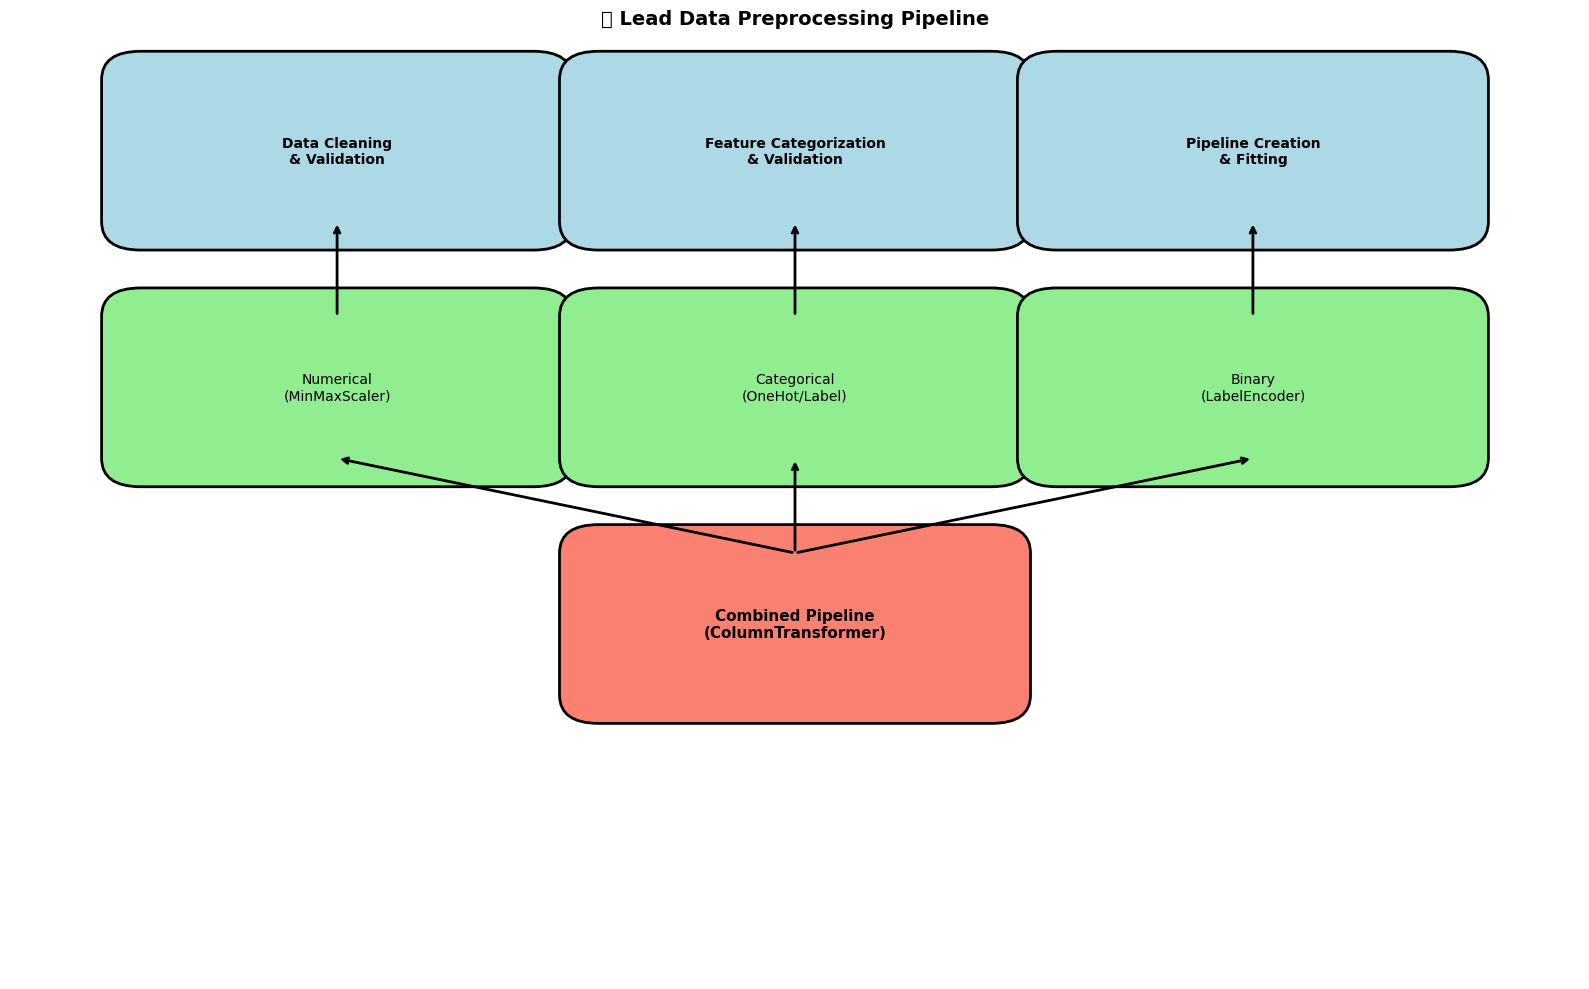

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_preprocessing_pipeline():
    """Visualizes the data preprocessing pipeline using matplotlib."""
    
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # --- Stage 1: Main pipeline boxes ---
    main_stages = [
        ("Data Cleaning\n& Validation", (1, 8)),
        ("Feature Categorization\n& Validation", (4.5, 8)),
        ("Pipeline Creation\n& Fitting", (8, 8))
    ]

    for text, (x, y) in main_stages:
        ax.add_patch(patches.FancyBboxPatch(
            (x, y), 3, 1.5, boxstyle="round,pad=0.3",
            edgecolor='black', facecolor='lightblue', linewidth=2
        ))
        ax.text(x + 1.5, y + 0.75, text, ha='center', va='center', fontsize=10, weight='bold')

    # --- Stage 2: Sub-transformers ---
    transformers = [
        ("Numerical\n(MinMaxScaler)", (1, 5.5)),
        ("Categorical\n(OneHot/Label)", (4.5, 5.5)),
        ("Binary\n(LabelEncoder)", (8, 5.5))
    ]

    for text, (x, y) in transformers:
        ax.add_patch(patches.FancyBboxPatch(
            (x, y), 3, 1.5, boxstyle="round,pad=0.3",
            edgecolor='black', facecolor='lightgreen', linewidth=2
        ))
        ax.text(x + 1.5, y + 0.75, text, ha='center', va='center', fontsize=10)

    # --- Stage 3: ColumnTransformer box ---
    ax.add_patch(patches.FancyBboxPatch(
        (4.5, 3), 3, 1.5, boxstyle="round,pad=0.3",
        edgecolor='black', facecolor='salmon', linewidth=2
    ))
    ax.text(6, 3.75, "Combined Pipeline\n(ColumnTransformer)", ha='center', va='center', fontsize=11, weight='bold')

    # --- Arrows between top and middle layers ---
    arrow_style = dict(arrowstyle="->", lw=2)

    for (start_x, start_y), (_, end_y) in zip([s[1] for s in main_stages], [t[1] for t in transformers]):
        ax.annotate("", xy=(start_x + 1.5, start_y), xytext=(start_x + 1.5, end_y + 1.5), arrowprops=arrow_style)

    # Arrows from all transformers to ColumnTransformer
    for x, _ in [t[1] for t in transformers]:
        ax.annotate("", xy=(x + 1.5, 5.5), xytext=(6, 4.5), arrowprops=arrow_style)

    # Title
    ax.set_title("🧹 Lead Data Preprocessing Pipeline", fontsize=14, weight='bold')

    plt.tight_layout()
    plt.show()
visualize_preprocessing_pipeline()